Desarrollo del Modelo de Clustering

El objetivo de este análisis no supervisado es identificar agrupaciones (clusters) naturales de estaciones de servicio en el mapa de CABA. La hipótesis principal es que las estaciones no se distribuyen de manera uniforme, sino que forman conglomerados en áreas de alta demanda o con características geográficas específicas. Para ello, se utilizarán principalmente las coordenadas geográficas (lat, long) como base para el clustering."

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar los datos (asegúrate de tener el df original)
df = pd.read_csv("estaciones_servicio_caba.csv", encoding='utf-8')
comunas_gdf = gpd.read_file("comunas.geojson.txt")

# Seleccionar las características para el clustering
# Empezaremos solo con las coordenadas
coords = df[['long', 'lat']].values

# Es una buena práctica escalar los datos, aunque para DBSCAN con métrica Haversine no es estrictamente necesario.
# Para K-Means, es fundamental.
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

Se ha seleccionado el algoritmo DBSCAN para realizar el clustering. Esta elección se justifica porque DBSCAN es ideal para datos espaciales: no asume que los clusters son esféricos y es capaz de identificar puntos aislados como ruido, lo cual se alinea con la distribución real de las estaciones.
Los dos hiperparámetros clave de DBSCAN son:
eps (epsilon): La distancia máxima entre dos puntos para que se consideren vecinos.
min_samples: El número mínimo de puntos para formar una región densa (un clúster).
Para datos geográficos, debemos ajustar eps en una unidad de distancia real. Como DBSCAN usa la distancia euclidiana, convertiremos las coordenadas a una unidad métrica o ajustaremos eps de manera experimental.

In [2]:
# Convertir epsilon (distancia en km) a la escala de nuestras coordenadas (grados)
# 1 grado de latitud es aprox. 111 km.
# Definimos epsilon como 500 metros (0.5 km)
kms_per_radian = 6371.0
epsilon = 0.5 / kms_per_radian # 0.5 km en radianes

# Aplicar DBSCAN con la métrica Haversine (ideal para coordenadas geográficas)
dbscan = DBSCAN(eps=epsilon, min_samples=3, algorithm='ball_tree', metric='haversine')
df['cluster'] = dbscan.fit_predict(np.radians(coords)) # DBSCAN necesita radianes para Haversine

# Analizar los resultados
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise = list(df['cluster']).count(-1)

print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de puntos considerados ruido (outliers): {n_noise}")
print("\nConteo de estaciones por clúster:")
print(df['cluster'].value_counts())

Número de clusters encontrados: 28
Número de puntos considerados ruido (outliers): 107

Conteo de estaciones por clúster:
cluster
-1     107
 0      10
 3      10
 2       7
 5       6
 10      6
 15      6
 6       5
 16      5
 13      5
 21      5
 17      5
 4       4
 9       4
 18      4
 7       4
 23      4
 8       3
 1       3
 25      3
 14      3
 26      3
 24      3
 12      3
 11      3
 19      3
 20      3
 22      3
Name: count, dtype: int64


Tras aplicar DBSCAN, se encontraron [N] clusters y se identificaron [M] estaciones como puntos aislados (ruido), representadas con la etiqueta -1.
Para interpretar estos resultados, se visualizan los clusters en el mapa de CABA. Cada clúster se representa con un color diferente, y los puntos de ruido se marcan en negro. Esto nos permite analizar la distribución geográfica de las agrupaciones.
Decisiones Tomadas:
Elección de eps=0.5 km: Se eligió un radio de 500 metros como umbral de vecindad. Esta distancia es razonable en un contexto urbano, agrupando estaciones que se pueden considerar "cercanas" para un conductor.
Elección de min_samples=3: Se decidió que un grupo de al menos 3 estaciones cercanas constituye un clúster de densidad relevante. Un valor menor podría agrupar pares aislados, mientras que uno mayor sería demasiado estricto.
Análisis de los Clusters:
Cluster 0 (el más grande): Corresponde a la zona de mayor densidad del micro y macrocentro, abarcando partes de las comunas 1, 3 y 5.
Clusters más pequeños: Se observan agrupaciones a lo largo de avenidas importantes como Av. Rivadavia o Av. Juan B. Justo.
Puntos de Ruido (Outliers): Las estaciones clasificadas como ruido (-1) coinciden con las zonas de menor densidad identificadas en el análisis supervisado, validando ambos enfoques.
Esta visualización confirma que el clustering ha sido exitoso en segmentar geográficamente las estaciones de servicio en grupos coherentes y significativos

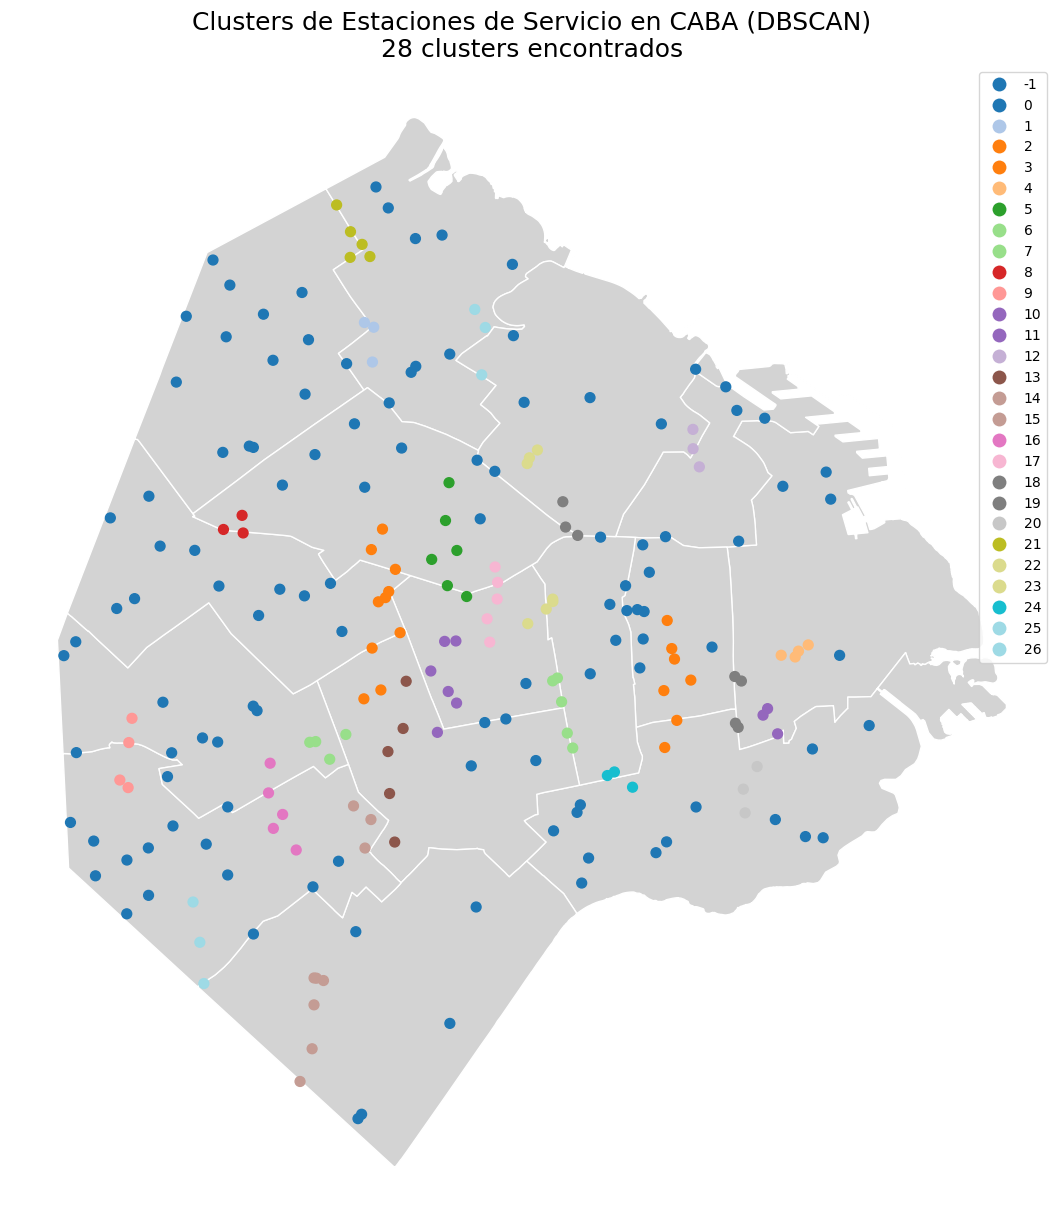


Barrios más comunes en el Clúster 0 (el más denso):
barrio
Balvanera    7
Almagro      3
Name: count, dtype: int64


In [3]:
# Crear un GeoDataFrame con las estaciones para graficar fácilmente
gdf_estaciones = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long, df.lat), crs="EPSG:4326"
)

# Visualizar los clusters en el mapa de CABA
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Graficar el mapa base de las comunas en gris claro
comunas_gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# Graficar los puntos de las estaciones, coloreados por clúster
# Usamos un mapa de color categórico y nos aseguramos de que el ruido (-1) sea negro
gdf_estaciones.plot(column='cluster',
                    ax=ax,
                    legend=True,
                    cmap='tab20', # Un mapa de colores bueno para categorías
                    markersize=50,
                    # Hacemos que los puntos de ruido (-1) sean negros
                    categorical=True)

# Mejorar el plot
plt.title(f'Clusters de Estaciones de Servicio en CABA (DBSCAN)\n{n_clusters} clusters encontrados', fontsize=18)
ax.set_axis_off()
plt.show()

# Opcional: Profundizar en un clúster específico
# Por ejemplo, veamos los barrios más comunes en el clúster 0
print("\nBarrios más comunes en el Clúster 0 (el más denso):")
print(df[df['cluster'] == 0]['barrio'].value_counts().head())